### Install MMdetectron 3.1 offline

In [1]:
!pip install --no-index --no-deps /kaggle/input/mmdetectron-31-wheel/pycocotools-2.0.6-cp310-cp310-linux_x86_64.whl
!pip install --no-index --no-deps /kaggle/input/mmdetectron-31-wheel/torch-1.12.1+cu116-cp310-cp310-linux_x86_64.whl
!pip install --no-index --no-deps /kaggle/input/mmdetectron-31-wheel/torchvision-0.13.1+cu116-cp310-cp310-linux_x86_64.whl
!pip install --no-index --no-deps /kaggle/input/mmdetectron-31-wheel/mmcv-2.0.1-cp310-cp310-manylinux1_x86_64.whl 
!pip install --no-index --no-deps /kaggle/input/mmdetectron-31-wheel/openmim-0.3.9-py2.py3-none-any.whl
!pip install --no-index --no-deps /kaggle/input/mmdetectron-31-wheel/mmengine-0.7.4-py3-none-any.whl
!pip install --no-index --no-deps /kaggle/input/mmdetectron-31-wheel/addict-2.4.0-py3-none-any.whl
!pip install --no-index --no-deps /kaggle/input/mmdetectron-31-wheel/mmdet-3.1.0-py3-none-any.whl
!pip install --no-index --no-deps /kaggle/input/mmdetectron-31-wheel/terminaltables-3.1.10-py2.py3-none-any.whl

Processing /kaggle/input/mmdetectron-31-wheel/pycocotools-2.0.6-cp310-cp310-linux_x86_64.whl
Processing /kaggle/input/mmdetectron-31-wheel/torch-1.12.1+cu116-cp310-cp310-linux_x86_64.whl
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0
    Uninstalling torch-2.0.0:
      Successfully uninstalled torch-2.0.0
Processing /kaggle/input/mmdetectron-31-wheel/torchvision-0.13.1+cu116-cp310-cp310-linux_x86_64.whl
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.1
    Uninstalling torchvision-0.15.1:
      Successfully uninstalled torchvision-0.15.1
Processing /kaggle/input/mmdetectron-31-wheel/mmcv-2.0.1-cp310-cp310-manylinux1_x86_64.whl
Processing /kaggle/input/mmdetectron-31-wheel/openmim-0.3.9-py2.py3-none-any.whl
Processing /kaggle/input/mmdetectron-31-wheel/mmengine-0.7.4-py3-none-any.whl
Processing /kaggle/input/mmdetectron-31-wheel/addict-2.4.0-py3-none-any.whl
Processing /kaggle/input/mmdetectron-31-wheel/mmdet-3.1.0-py3-no

### Importing Libraries

In [2]:
from itertools import groupby
from pycocotools import mask as mutils
from pycocotools.coco import COCO
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import os
import cv2,glob
import matplotlib.pyplot as plt
import wandb
from PIL import Image
import gc
sample = None
import mmcv
from glob import glob
import matplotlib.pyplot as plt
from mmdet.apis import init_detector, inference_detector

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

import mmdet as mmdet
print(mmdet.__version__)

from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

1.12.1+cu116 True
3.1.0
11.6
GCC 9.3


### Function

### Test Dataset and DataLoader

In [4]:
import os
import numpy as np
import torch
from PIL import Image


class WheatDataset(torch.utils.data.Dataset):
    def __init__(self, imgs):
        self.imgs = imgs
        self.name_indices = [os.path.splitext(os.path.basename(i))[0] for i in imgs]
    def __getitem__(self, idx):
        # load images and masks
        img_path = self.imgs[idx]
        name = self.name_indices[idx]
        array = tiff.imread(img_path)
        img = Image.fromarray(array)
        return img, name
    def __len__(self):
        return len(self.imgs)
    
all_imgs = glob('/kaggle/input/global-wheat-detection/test/*.jpg')
dataset_test = WheatDataset(all_imgs)
test_dl = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

### Model

In [5]:
!python /kaggle/input/global-wheat-detection-mmdetection-3-1-train/mmdetection/tools/analysis_tools/analyze_logs.py plot_curve /kaggle/input/global-wheat-detection-mmdetection-3-1-train/mmdetection/work_dirs/custom_config/20231118_122609/vis_data/20231118_122609.json --out output.png

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Traceback (most recent call last):
  File "/kaggle/input/global-wheat-detection-mmdetection-3-1-train/mmdetection/tools/analysis_tools/analyze_logs.py", line 211, in <module>
    main()
  File "/kaggle/input/global-wheat-detection-mmdetection-3-1-train/mmdetection/tools/analysis_tools/analyze_logs.py", line 205, in main
    log_dicts = load_json_logs(json_logs)
  File "/kaggle/input/global-wheat-detection-mmdetection-3-1-train/mmdetection/tools/analysis_tools/analyze_logs.py", line 171, in load_json_logs
    with open(json_log, 'r') as log_file:
FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/global-wheat-detection-mmdetection-3-1-train/mmdetection/work_dirs/custom_config/20231118_122609/vis_data/20231118_122609.json'

In [6]:
from mmdet.apis import init_detector, inference_detector
from mmengine.config import Config
config_file = '/kaggle/input/global-wheat-detection-mmdetection-3-1-train/mmdetection/work_dirs/custom_config/custom_config.py'
checkpoint_file = '/kaggle/input/global-wheat-detection-mmdetection-3-1-train/mmdetection/work_dirs/custom_config/epoch_10.pth'

cfg = Config.fromfile(config_file )
model = init_detector(cfg, checkpoint_file, device=device)


Loads checkpoint by local backend from path: /kaggle/input/global-wheat-detection-mmdetection-3-1-train/mmdetection/work_dirs/custom_config/epoch_10.pth


### Predicting

In [7]:
ids = []
prediction_strings = []

for img in tqdm(all_imgs):
    img_array = mmcv.imread(img,channel_order='rgb')
    [h, w, c] = img_array.shape 
    pred = inference_detector(model,img)
    previous_masks = []
    masks_use = []
    labels_use = []
    pred_string = ""
    for i, bbox in enumerate(pred.pred_instances["bboxes"]):
        # Filter-out low-scoring results.
        score = pred.pred_instances["scores"][i].cpu().item()
#         if score < 0.5:
#             continue
        bbox = list(map(int,bbox))
#         print(bbox)
        pred_string += f"{score} {bbox[0]} {bbox[1]} {bbox[2] - bbox[0]} {bbox[3] - bbox[1]} "
    ids.append(str(img).split('.')[0].split('/')[-1])
    prediction_strings.append(pred_string.rstrip())

  0%|          | 0/10 [00:00<?, ?it/s]

0 [897, 328, 1003, 418] 0.9894123673439026
1 [711, 824, 818, 916] 0.9823399186134338
2 [0, 452, 65, 529] 0.9730871915817261
3 [508, 787, 593, 872] 0.9613320231437683
4 [353, 0, 425, 56] 0.9555853605270386
5 [621, 37, 692, 111] 0.9378941655158997
6 [71, 86, 205, 168] 0.9327762722969055
7 [944, 80, 1024, 168] 0.9122503399848938
8 [376, 628, 481, 751] 0.770286500453949
9 [195, 478, 274, 555] 0.7507532835006714
10 [246, 0, 345, 45] 0.723599374294281
11 [433, 193, 497, 278] 0.6751875877380371
12 [682, 719, 756, 811] 0.6503557562828064
13 [297, 302, 375, 398] 0.6437643766403198
14 [249, 325, 348, 560] 0.6379044651985168
15 [471, 261, 577, 365] 0.2147703766822815
16 [212, 686, 301, 758] 0.15810632705688477
17 [235, 839, 329, 911] 0.14017917215824127
18 [205, 468, 317, 559] 0.09623982012271881
19 [0, 752, 34, 871] 0.08848303556442261
20 [0, 836, 46, 961] 0.06592293828725815
21 [0, 755, 44, 937] 0.05693685635924339


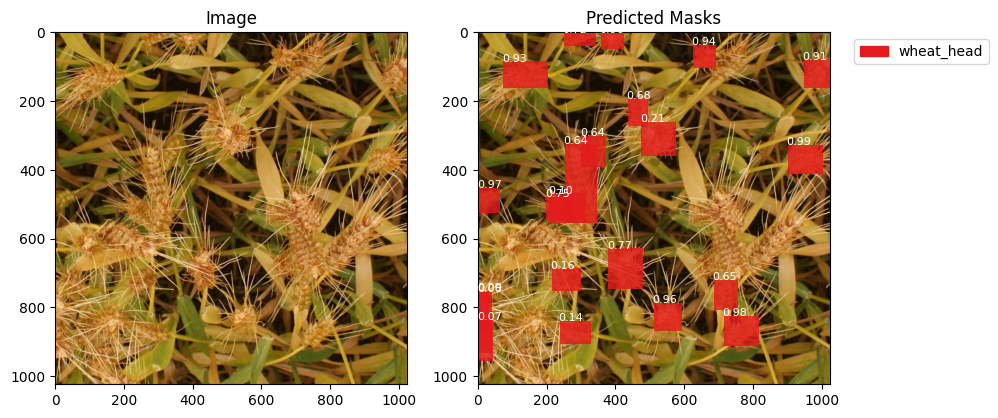

In [8]:
colors = ["Set1"] 
legend = {0: 'wheat_head'} 
from skimage import io
import matplotlib.patches as mpatches
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
I = io.imread(str(all_imgs[0]))
axs[0].imshow(I)
axs[0].set_title('Image')
axs[1].imshow(I)
img = all_imgs[0]
pred = inference_detector(model,img)
for i, bbox in enumerate(pred.pred_instances["bboxes"]):
    # Filter-out low-scoring results.
    score = pred.pred_instances["scores"][i].cpu().item()
#     if score < 0.5:
#         continue
    label = pred.pred_instances["labels"][i].cpu().item()
    mask = np.zeros((1024, 1024),dtype=np.uint8)
    color = colors[label]
    bbox = list(map(int,bbox))
    mask[bbox[1]:bbox[3], bbox[0]:bbox[2]] = 1
    mask = np.ma.masked_where(mask == 0, mask)
    axs[1].imshow(mask, cmap = color, alpha=0.8)
    axs[1].set_title('Predicted Masks')
    # Add score text on each segment
    print(i, bbox, score)
    axs[1].text(bbox[0], bbox[1], f"{score:.2f}", color='white', fontsize=8)
    handles = []
    for cl in legend:
        color = colors[cl]
        handles.append(mpatches.Patch(color=plt.colormaps.get_cmap(color)(0)))
    axs[1].legend(handles, legend.values(), bbox_to_anchor=(1.05, 1), loc='upper left')

### submission

In [9]:
submission = pd.DataFrame()
submission['image_id'] = ids
submission['PredictionString'] = prediction_strings
submission = submission.set_index('image_id')
submission.to_csv("submission.csv")
submission.head()

,PredictionString
image_id,
796707dd7,0.9894123673439026 897 328 106 90 0.9823399186...
2fd875eaa,0.9967568516731262 106 583 138 79 0.9955484867...
cc3532ff6,0.9971321821212769 378 0 77 92 0.9903762936592...
53f253011,0.994779109954834 619 97 124 144 0.99266439676...
f5a1f0358,0.9915401339530945 0 841 64 108 0.989731729030...
